In [16]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyproj
import scipy
from scipy.signal import savgol_filter
from dask.distributed import Client
import dask
import rasterio as rio
import numpy as np
import seaborn as sb

In [17]:
client = Client()

/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56500 instead
  warnings.warn(


In [18]:
HySpexPth = Path("/Volumes/FIREICE/fihyper/cwaigl/")
subpath = "03_products/cropped_masked_final/"
filepatt = "VNIR_SWIR_rad_geo_atm_bcor_crop.bsq"

---

Testing 1-2-3

In [19]:
locations_fn = Path("/Volumes/FIREICE/fiboreal/cwaigl/2021-HySpex_fuels/GIS/veg_locations/CW_pixel_labels01.gpkg") 

In [20]:
vegsamples = gp.read_file(locations_fn)
vegsamples

,fileprefix,flightline,species,vegclass,context,geometry
0,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437394.000 7176015.968)
1,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437394.075 7176011.042)
2,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437394.000 7176012.012)
3,20210803-BC,03,black spruce,Open Black Spruce Forest,crown,POINT (437412.061 7176012.982)
4,20210803-BC,03,understory,Open Black Spruce Forest,semi-shade,POINT (437421.091 7176034.999)
...,...,...,...,...,...,...
856,20210803-BC,04,quaking aspen,None,crown,POINT (436797.075 7178624.945)
857,20210803-BC,04,quaking aspen,None,crown,POINT (436797.075 7178625.807)
858,20210803-BC,04,quaking aspen,None,crown,POINT (436788.972 7178624.055)
859,20210803-BC,04,quaking aspen,None,crown,POINT (436800.063 7178615.981)


In [21]:
vegsamples[vegsamples.context=='open'].species.value_counts()

graminoid                      67
asphalt                        33
water                          27
understory                     23
gravel                         19
sedges dead                    12
shrub (rose/bearberry)         11
shrub (betula nana / salix)    10
dead wood                       4
Name: species, dtype: int64

In [22]:
vegsamples.species.value_counts()

understory                     205
white spruce                   153
quaking aspen                   98
paper birch                     87
graminoid                       83
black spruce                    51
gravel                          50
asphalt                         33
water                           27
shrub (betula nana / salix)     20
sedges dead                     12
shrub (rose/bearberry)          11
alder                            9
bare soil                        9
tamarack                         8
dead wood                        4
alder/willow                     1
Name: species, dtype: int64

In [23]:
vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown')].species.value_counts()

white spruce     67
paper birch      34
black spruce     25
quaking aspen    21
alder             3
graminoid         3
tamarack          2
Name: species, dtype: int64

In [24]:
subsample = pd.concat([
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='black spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='black spruce')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='paper birch')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='paper birch')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='quaking aspen')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='crown') & (vegsamples.species=='quaking aspen')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='open') & (vegsamples.species=='graminoid')].sample(n=10),
    vegsamples[(vegsamples.fileprefix=='20200830-BC') & (vegsamples.context=='open') & (vegsamples.species=='graminoid')].sample(n=10),
    vegsamples[(vegsamples.context=='open') & (vegsamples.species=='gravel')],
])

In [25]:
subsample[['fileprefix', 'flightline']].drop_duplicates() 

,fileprefix,flightline
827,20210803-BC,03
561,20210803-BC,04
550,20200830-BC,04
630,20210803-BC,06
795,20210803-BC,01
743,20200830-BC,05
620,20200830-BC,03
691,20210803-BC,02


In [26]:
subsample

,fileprefix,flightline,species,vegclass,context,geometry
827,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (436827.158 7176667.968)
442,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437120.004 7176564.949)
294,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436977.888 7176308.871)
561,20210803-BC,04,white spruce,None,crown,POINT (436704.175 7178212.955)
562,20210803-BC,04,white spruce,None,crown,POINT (436703.189 7178218.994)
...,...,...,...,...,...,...
555,20210803-BC,04,gravel,trail,open,POINT (436724.142 7178207.840)
556,20210803-BC,04,gravel,trail,open,POINT (436724.881 7178205.929)
557,20210803-BC,04,gravel,trail,open,POINT (436725.189 7178197.979)
558,20210803-BC,04,gravel,trail,open,POINT (436725.991 7178193.665)


In [27]:
def get_datafile(row, smooth=True):
    fpth = HySpexPth / f"{row.fileprefix.replace('-', '_')}" / subpath / f"{row.fileprefix}_{row.flightline}_{filepatt}"
    return fpth

In [28]:
def get_singlefilesampledf(labelrow):
    return subsample[(subsample.fileprefix==labelrow.fileprefix) & (subsample.flightline==labelrow.flightline)]

def get_dataset(fpth):
    testdata = xr.open_dataset(fpth, engine="rasterio")
    testdata.attrs['long_name'] = "spectral reflectance, %*100"
    testdata.attrs['name'] = "spectral reflectance, %*100"
    testdata['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"
    return testdata

def get_spectra_fromsingle(samplerow, dataset='dummy'):
    pt = samplerow.geometry
    print(pt)
    spectrum = dataset.band_data.sel(x=pt.x, y=pt.y, method='nearest').values[:-10]
    return {samplerow.species: spectrum}

def get_spectra(labelrow):
    subsubsample = get_singlefilesampledf(labelrow)
    fn = get_datafile(labelrow)
    print(f"working on {fn}")
    testdata = get_dataset(fn)
    print("Got dataset opened") 
    for idx, row in subsubsample.iterrows():
        print(f"   working on {idx}, {row.species} at {row.geometry}") 
        dicitem = get_spectra_fromsingle(row, dataset=testdata)
        print(dicitem)
    #testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]

In [15]:
labeldf = subsample[['fileprefix', 'flightline']].drop_duplicates()
for idx, row in labeldf.iterrows():
    get_spectra(row)

working on /Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq


KeyboardInterrupt: 

In [149]:
row = next(labeldf.iterrows())[1]

In [150]:
row

fileprefix    20210803-BC
flightline             04
Name: 563, dtype: object

In [147]:
subsample

,fileprefix,flightline,species,vegclass,context,geometry
563,20210803-BC,04,white spruce,None,crown,POINT (436685.995 7178216.899)
423,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437026.109 7176200.958)
346,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437129.028 7176208.997)
292,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436972.888 7176336.933)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
...,...,...,...,...,...,...
555,20210803-BC,04,gravel,trail,open,POINT (436724.142 7178207.840)
556,20210803-BC,04,gravel,trail,open,POINT (436724.881 7178205.929)
557,20210803-BC,04,gravel,trail,open,POINT (436725.189 7178197.979)
558,20210803-BC,04,gravel,trail,open,POINT (436725.991 7178193.665)


In [191]:
fn = Path("/Volumes/FIREICE/fihyper/cwaigl/20210803_BC/03_products/cropped_masked_final/20210803-BC_04_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
testdata = get_dataset(fn)
sampledf = get_singlefilesampledf(row)
pt = sampledf.iloc[0].geometry
testdata.band_data.sel(x=pt.x, y=pt.y, method='nearest').values

Task exception was never retrieved
future: <Task finished name='Task-166487' coro=<Client._gather.<locals>.wait() done, defined at /Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/client.py:1999> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/client.py", line 2004, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [170]:
testdata = get_dataset(fn)values

In [171]:
testdata

<xarray.Dataset>
Dimensions:      (band: 459, x: 1320, y: 8506)
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(459,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(459,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.361e+05 4.361e+05 ... 4.374e+05 4.374e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(459, 400, 200), meta=np.ndarray>
Attributes:
    long_name:  spectral reflectance, %*100
    name:       spectral reflectance, %*100

In [160]:
print(pt.x)

436685.99462613644


In [173]:
testdata.swap_dims({'band': 'wavelength'})

Task exception was never retrieved
future: <Task finished name='Task-165940' coro=<Client._gather.<locals>.wait() done, defined at /Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/client.py:1999> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/client.py", line 2004, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [172]:
testdata.band_data.sel(x=pt.x, y=pt.y, method='nearest')[:-10]

<xarray.DataArray 'band_data' (band: 449)>
dask.array<getitem, shape=(449,), dtype=float32, chunksize=(449,), chunktype=numpy.ndarray>
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(449,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(449,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 443 444 445 446 447 448 449
    x            float64 4.367e+05
    y            float64 7.178e+06
    spatial_ref  int64 ...
Attributes:
    wavelength:                410.36
    wavelength_units:          nm
    long_name:                 spectral reflectance, %*100
    acquisition_time:          2021-08-03T21:23:05.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 436107.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1320
    sun_azimuth:               168.27
    sun_elevation:             42.27
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

In [64]:
subsample

,fileprefix,flightline,species,vegclass,context,geometry
563,20210803-BC,04,white spruce,None,crown,POINT (436685.995 7178216.899)
423,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437026.109 7176200.958)
346,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437129.028 7176208.997)
292,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436972.888 7176336.933)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
...,...,...,...,...,...,...
555,20210803-BC,04,gravel,trail,open,POINT (436724.142 7178207.840)
556,20210803-BC,04,gravel,trail,open,POINT (436724.881 7178205.929)
557,20210803-BC,04,gravel,trail,open,POINT (436725.189 7178197.979)
558,20210803-BC,04,gravel,trail,open,POINT (436725.991 7178193.665)


In [40]:
vegsamples[(vegsamples.fileprefix=='20210803-BC') & (vegsamples.context=='crown') & (vegsamples.species=='white spruce')].sample(n=20)

,fileprefix,flightline,species,vegclass,context,geometry
421,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437024.876 7176200.071)
297,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (436984.083 7176329.768)
343,20210803-BC,03,white spruce,Closed Quaking Aspen/White Spruce Forest,crown,POINT (437132.184 7176207.764)
440,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437098.256 7176582.899)
438,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437105.111 7176567.908)
843,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437274.998 7176618.834)
424,20210803-BC,03,white spruce,Closed Spruce/Paper Birch Forest,crown,POINT (437045.884 7176196.915)
442,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437120.004 7176564.949)
303,20210803-BC,03,white spruce,Closed White Spruce Forest,crown,POINT (437004.009 7176328.798)
835,20210803-BC,03,white spruce,Open White Spruce Forest,crown,POINT (437064.152 7176639.981)


2022-05-09 12:18:17,698 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7fdd201e1a30>>, <Task finished name='Task-14' coro=<Worker.close() done, defined at /Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/worker.py:1385> exception=CommClosedError('ConnectionPool not running. Status: Status.closed')>)
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/distributed/core.py", line 1089, in connect
    comm = await fut
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/

In [37]:
treespecies = ['paper birch', 'quaking aspen', 'black spruce', 'white spruce']

In [9]:
testdata = xr.open_dataset(testfile, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400})
testdata.attrs['long_name'] = "spectral reflectance, %*100"
testdata.attrs['name'] = "spectral reflectance, %*100"
testdata['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"

In [10]:
samples = {}

for name in [ 'paper birch', 'black spruce', 'white spruce', 'quaking aspen']:
    samples[name] = [(pt.x, pt.y) for pt in vegsamples[vegsamples.species == name].geometry]

In [11]:
samples

{'paper birch': [(437262.92226200976, 7176632.010586323),
  (437273.0125433474, 7176643.989422992),
  (437032.11224156746, 7176182.9582265),
  (437032.1868737827, 7176183.928445298),
  (437043.00854499324, 7176189.973654733),
  (437041.9636939798, 7176184.003077514),
  (437043.0831772085, 7176183.032858714),
  (437031.1420227692, 7176183.853813083),
  (437030.91812612343, 7176194.974013154),
  (437021.99957640184, 7176164.822598194),
  (437021.99957640184, 7176164.001643826),
  (437023.0444274153, 7176164.001643826),
  (437024.0892784287, 7176163.852379396),
  (437024.76096836594, 7176164.038959933),
  (437457.026862444, 7176031.006141625),
  (437455.08642484696, 7176071.988556821),
  (437454.0415738335, 7176073.033407834),
  (437481.0584357521, 7176065.943347386),
  (437474.0430075191, 7176086.91499987),
  (437456.13127586036, 7176068.033049413),
  (437454.78789598594, 7176067.958417198),
  (437469.11728131294, 7176061.987839978),
  (437474.0430075191, 7176079.003985054),
  (437473.96

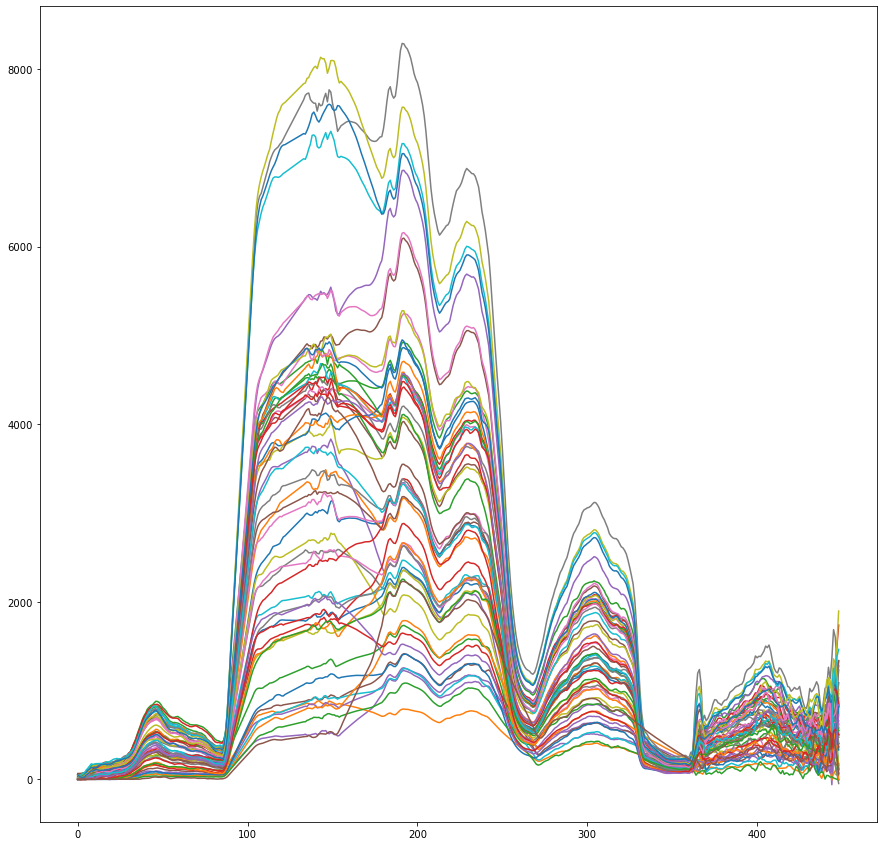

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['paper birch']: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

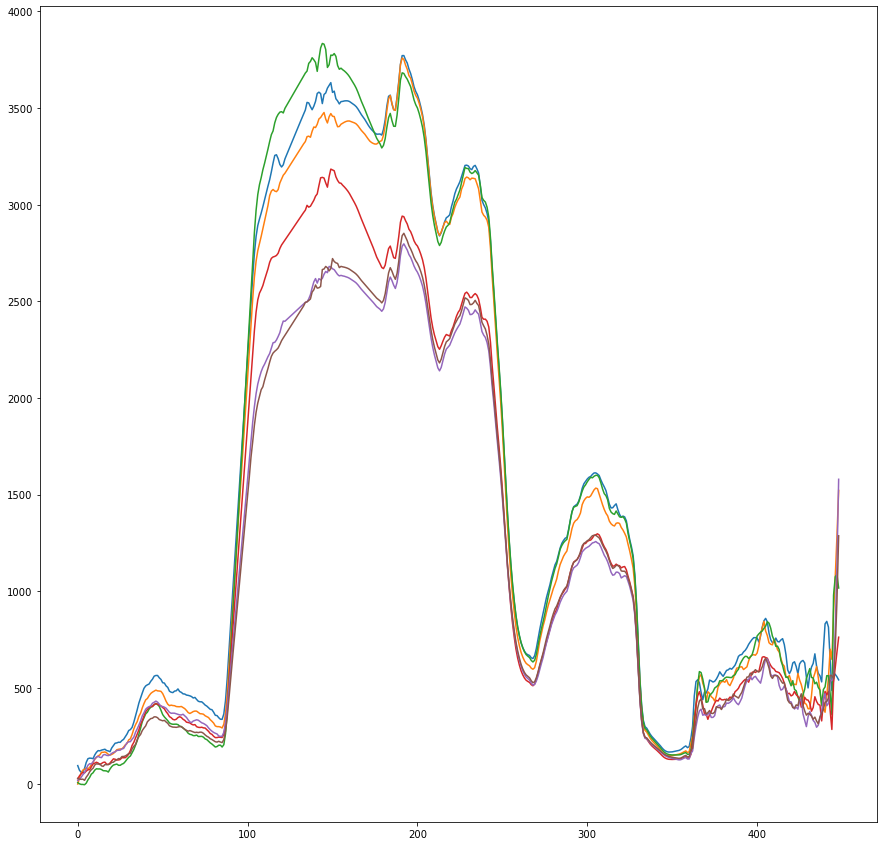

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['quaking aspen'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

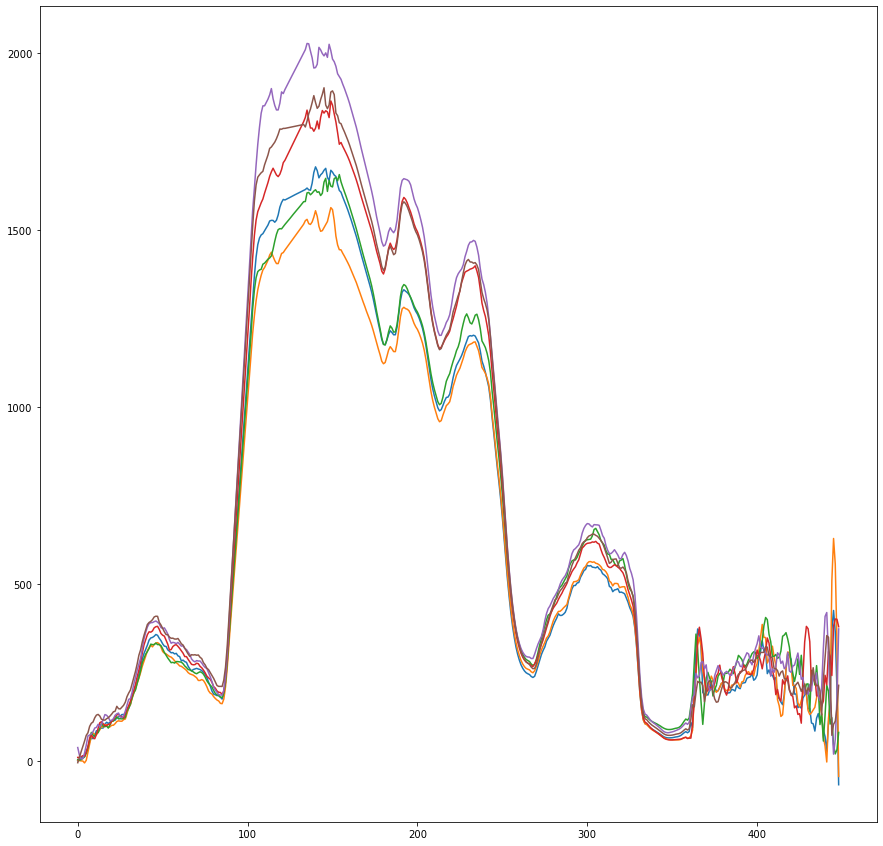

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

for pt in samples['black spruce'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
    ax.plot(savgol_filter(spec, 7, 2))

In [26]:
skipSWIR = -15
wavelengths = testdata.wavelength.values[:skipSWIR]

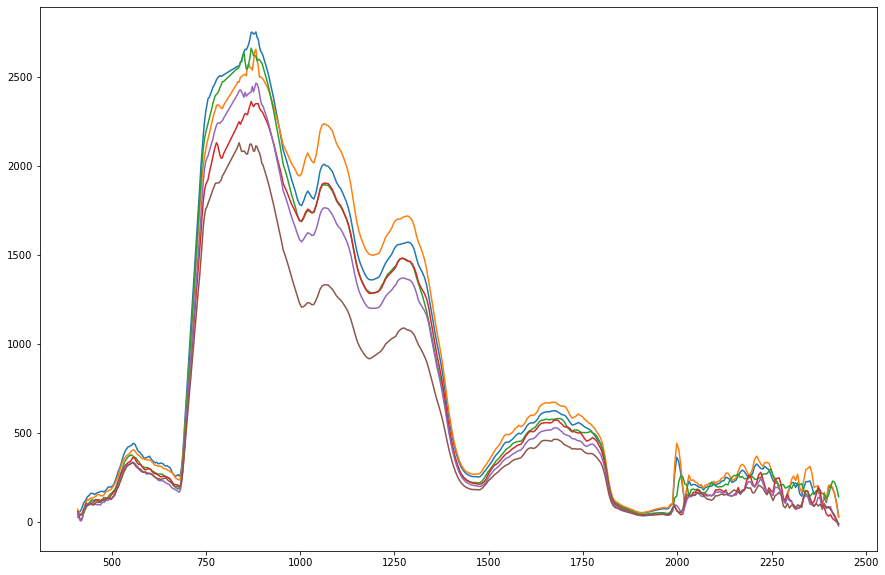

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

for pt in samples['white spruce'][:6]: 
    spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:skipSWIR]
    ax.plot(wavelengths, savgol_filter(spec, 7, 2))

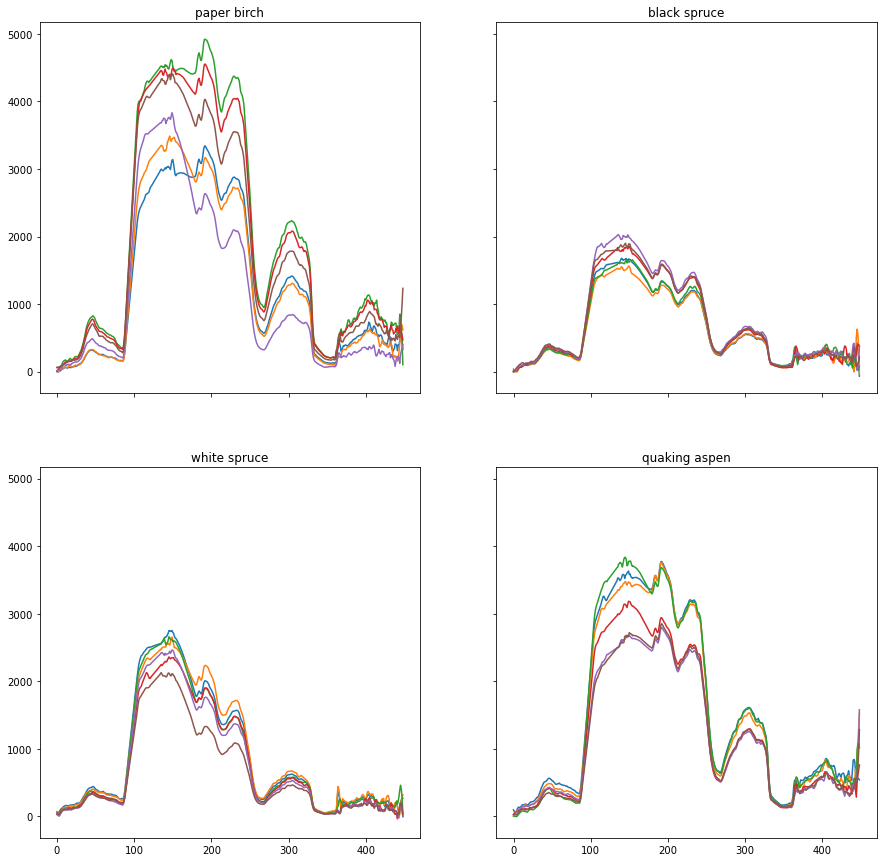

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)


for ii, ax in enumerate(axs.flatten()):
    for pt in samples[speciesnames[ii]][:6]: 
        spec = testdata.swap_dims({'band': 'wavelength'}).band_data.sel(x=pt[0], y=pt[1], method='nearest')[:-10]
        ax.plot(savgol_filter(spec, 7, 2))
        ax.set_title(speciesnames[ii]) 
    